In [1]:
# ignore warnings
import warnings

warnings.filterwarnings("ignore")

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml


# Load data

In [2]:
def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True).data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


try:
    # load data from local pickle
    df = pd.read_pickle("mtpl2.pkl")
except FileNotFoundError:
    # or download from openml
    df = load_mtpl2()
    df.to_pickle("mtpl2.pkl")

df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0
3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0
5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0
10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0
11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0


Feature names
- IDpol: policy number (unique identifier); 
- ClaimNb: number of claims on the given policy; 
- Exposure: total exposure in yearly units;
- Area: area code (categorical, ordinal);
- VehPower: power of the car (categorical, ordinal)
- VehAge: age of the car in years; 
- DrivAge: age of the (most common) driver in years
- BonusMalus: bonus-malus level between 50 and 230 (with reference level 100); 
- VehBrand: car brand (categorical, nominal); 
- VehGas: diesel or regular fuel car (binary); 
- Density: density of inhabitants per km2 in the city of the living place of the driver; 
- Region: regions in France (prior to 2016)
- ClaimAmount: total claim amount.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 678013 entries, 1 to 6114330
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ClaimNb      678013 non-null  int64   
 1   Exposure     678013 non-null  float64 
 2   Area         678013 non-null  category
 3   VehPower     678013 non-null  int64   
 4   VehAge       678013 non-null  int64   
 5   DrivAge      678013 non-null  int64   
 6   BonusMalus   678013 non-null  int64   
 7   VehBrand     678013 non-null  category
 8   VehGas       678013 non-null  object  
 9   Density      678013 non-null  int64   
 10  Region       678013 non-null  category
 11  ClaimAmount  678013 non-null  float64 
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 53.7+ MB


In [4]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


# preprocess data

In [5]:
# Remove outliers
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

# If the claim amount is 0, then we do not count it as a claim. The loss function
# used by the severity model needs strictly positive claim amounts. This way
# frequency and severity are more consistent with each other.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

df["Frequency"] = df["ClaimNb"] / df["Exposure"]
# df = df.drop(columns=["ClaimNb", "Exposure", "ClaimAmount"])
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency
IDpol,,,,,,,,,,,,,
1,0,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0
3,0,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0
5,0,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0
10,0,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0
11,0,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0,0.0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0,0.0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0,0.0


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

# log_scale_transformer = make_pipeline(
#     FunctionTransformer(func=np.log), StandardScaler()
# )
# 
# column_trans = ColumnTransformer(
#     [
#         (
#             "BN",  # binned_numeric
#             KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
#             ["VehAge", "DrivAge"],
#         ),
#         (
#             "OH",  # onehot_categorical
#             OneHotEncoder(),
#             ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
#         ),
#         # ("passthrough_numeric", "passthrough", ["BonusMalus"]),
#         # ("log_scaled_numeric", log_scale_transformer, ["Density"]),
#     ],
#     remainder="passthrough",
# )
# 
# df = pd.DataFrame(column_trans.fit_transform(df).toarray(), columns=column_trans.get_feature_names_out())
# df = df.rename(
#     columns={_: _.replace("__", "_") if "remainder__" not in _ else _.replace("remainder__", "") for _ in df.columns})


# set categorical columns
categorical_columns = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
df[categorical_columns] = df[categorical_columns].astype("category")

# standard_scaler = StandardScaler()
# df["Density"] = standard_scaler.fit_transform(np.log(df["Density"]).values.reshape(-1, 1))
df["Density"] = np.log(df["Density"])
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency
IDpol,,,,,,,,,,,,,
1,0,0.10000,D,5,0,55,50,B12,Regular,7.104144,R82,0.0,0.0
3,0,0.77000,D,5,0,55,50,B12,Regular,7.104144,R82,0.0,0.0
5,0,0.75000,B,6,2,52,50,B12,Diesel,3.988984,R22,0.0,0.0
10,0,0.09000,B,7,0,46,50,B12,Diesel,4.330733,R72,0.0,0.0
11,0,0.84000,B,7,0,46,50,B12,Diesel,4.330733,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,8.106816,R93,0.0,0.0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9.195227,R11,0.0,0.0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,7.187657,R82,0.0,0.0


In [7]:
# split train test data
from sklearn.model_selection import train_test_split

X = df.drop(columns=["ClaimNb", "Exposure", "ClaimAmount", "Frequency"])
y = df[["ClaimNb", "Exposure", "ClaimAmount", "Frequency"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

y_train_exposure = y_train["Exposure"]
y_test_exposure = y_test["Exposure"]

y_train = y_train["ClaimNb"]
y_test = y_test["ClaimNb"]

In [8]:
X_train

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,
3053827,A,4,16,48,50,B2,Regular,3.367296,R24
2185396,B,6,6,40,50,B2,Diesel,4.510860,R52
2235135,B,4,3,18,100,B2,Regular,4.158883,R91
19279,E,7,4,54,50,B10,Diesel,8.322637,R24
3054849,A,4,10,36,50,B2,Regular,2.639057,R24
...,...,...,...,...,...,...,...,...,...
3006800,D,6,10,25,85,B2,Diesel,6.654153,R93
1123120,C,6,8,40,50,B1,Diesel,6.003887,R24
1058973,C,13,9,50,50,B10,Regular,5.308268,R53


In [9]:
y_train

IDpol
3053827    0
2185396    0
2235135    0
19279      0
3054849    0
          ..
3006800    0
1123120    0
1058973    0
3157206    0
2217521    0
Name: ClaimNb, Length: 542410, dtype: int64

In [10]:
def get_score(y_test, y_pred, weight=None):
    from sklearn.metrics import mean_squared_error, mean_poisson_deviance, mean_absolute_error, max_error
    if np.any(y_pred < 0):
        print("Negative predictions found, replacing with 0")
        y_pred = np.where(y_pred < 0, np.finfo(float).eps, y_pred)

    print(f"MSE: {mean_squared_error(y_test, y_pred, sample_weight=weight):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred, sample_weight=weight):.4f}")
    print(f"Max Error: {max_error(y_test, y_pred):.4f}")
    # print(f"Mean Poisson Deviance: {mean_poisson_deviance(y_test, y_pred, sample_weight=weight):.4f}")


def plot_pred_vs_actual(y_pred, y_test, length=1000):
    length = min(length, len(y_pred))
    fig, ax = plt.subplots(figsize=(30, 5))
    fig.suptitle('Predicted versus actual counts')
    ax.plot(np.arange(length), y_pred[:length], 'g-', alpha=0.5, label='predicted')
    ax.plot(np.arange(length), y_test.tolist()[:length], 'r-', alpha=0.1, label='actual')
    ax.set_xlabel('index')
    ax.set_ylabel('claim count')
    ax.legend()
    plt.show()


# Intercept Only Model

In [11]:
from statsmodels.discrete.count_model import Poisson

formula = "ClaimNb ~ 1"
iom = Poisson.from_formula(formula, data=X_train.join(y_train), offset=np.log(y_train_exposure)).fit()
iom.summary()

Optimization terminated successfully.
         Current function value: 0.164000
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542410
Model:                        Poisson   Df Residuals:                   542409
Method:                           MLE   Df Model:                            0
Date:                Tue, 30 Jan 2024   Pseudo R-squ.:               3.139e-11
Time:                        20:39:14   Log-Likelihood:                -88955.
converged:                       True   LL-Null:                       -88955.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6062      0.007   -379.054      0.000      -2.620      -2.593
==============================================================================
"""

In [12]:
y_pred = iom.predict(X_test, offset=np.log(y_test_exposure))

get_score(y_test, y_pred)

MSE: 0.0417
MAE: 0.0740
Max Error: 3.9948


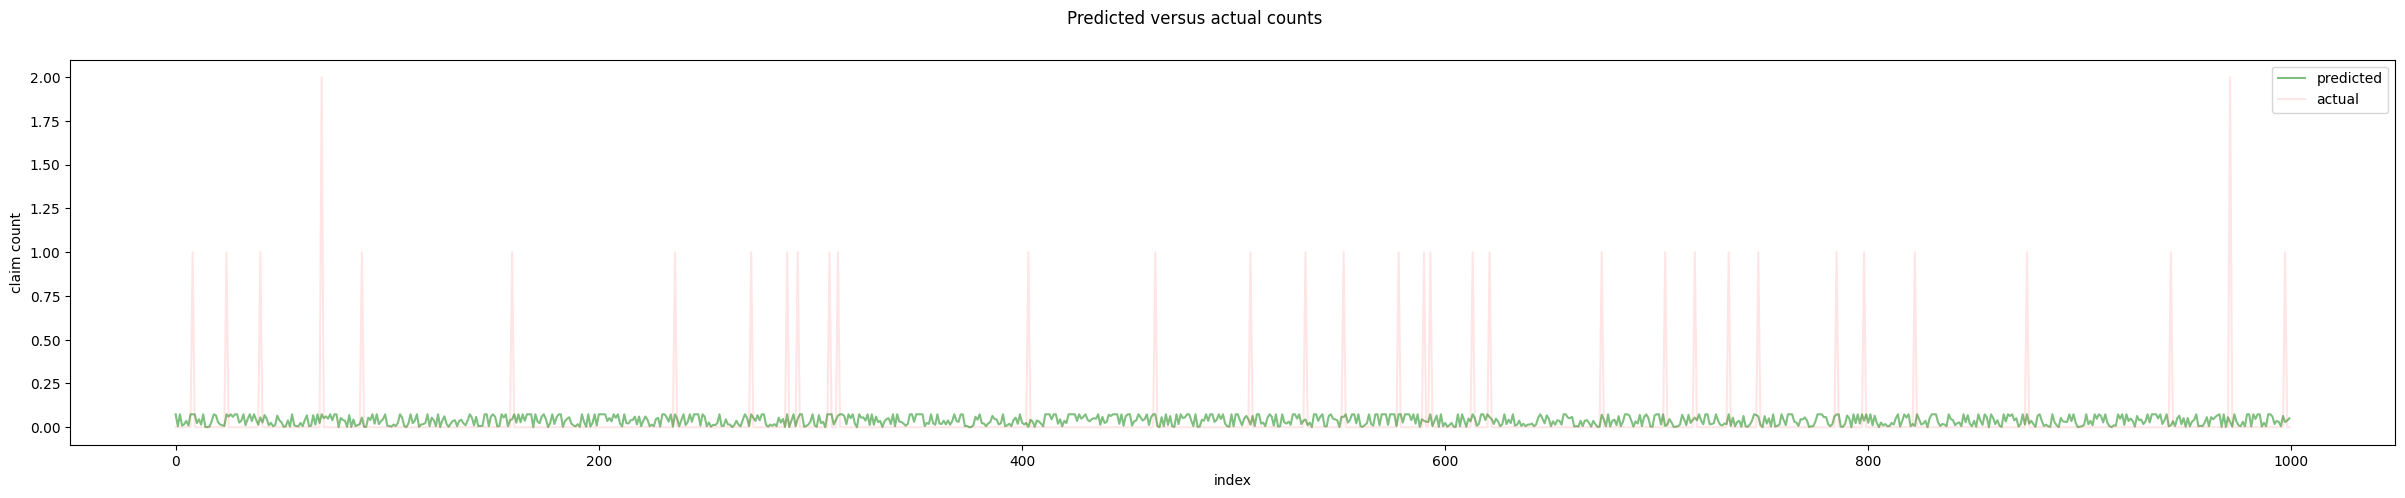

In [13]:

plot_pred_vs_actual(y_pred, y_test)

# Linear Regression

In [14]:
from statsmodels.regression.linear_model import OLS

formula = "ClaimNb ~ " + " + ".join(X_train.columns)
lr = OLS.from_formula(formula, data=X_train.join(y_train), offset=np.log(y_train_exposure)).fit()
lr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ClaimNb   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     87.87
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:39:17   Log-Likelihood:            -1.0209e+06
No. Observations:              542410   AIC:                         2.042e+06
Df Residuals:                  542357   BIC:                         2.042e+06
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0623      0.003    -18.506      0.000      -0.069      -0.056
Area[T.B]             0.0017      0.001      1.271      0.204      -0.001       0.004
Area[T.C]             0.0021      0.002      1.210      0.226      -0.001       0.005
Area[T.D]             0.0052      0.003      1.975      0.048    3.86e-05       0.010
Area[T.E]             0.0049      0.003      1.403      0.161      -0.002       0.012
Area[T.F]             0.0073      0.005      1.506      0.132      -0.002       0.017
VehPower[T.5]         0.0031      0.001      3.198      0.001       0.001       0.005
VehPower[T.6]         0.0050      0.001      5.281      0.000       0.003       0.007
VehPower[T.7]         0.0028      0.001      3.017      0.003       0.001       0.005
VehPower[T.8]         0.0037      0.001      2.842      0.004       0.001       0.006
VehPower[T.9]         0.0062      0.001      4.133      0.000       0.003       0.009
VehPower[T.10]        0.0100      0.001      6.717      0.000       0.007       0.013
VehPower[T.11]        0.0101      0.002      5.455      0.000       0.006       0.014
VehPower[T.12]        0.0102      0.003      3.845      0.000       0.005       0.015
VehPower[T.13]        0.0106      0.004      2.521      0.012       0.002       0.019
VehPower[T.14]        0.0070      0.005      1.458      0.145      -0.002       0.016
VehPower[T.15]        0.0070      0.004      1.641      0.101      -0.001       0.015
VehBrand[T.B10]      -0.0013      0.002     -0.679      0.497      -0.005       0.002
VehBrand[T.B11]       0.0042      0.002      2.000      0.046    8.42e-05       0.008
VehBrand[T.B12]      -0.0186      0.001    -19.759      0.000      -0.020      -0.017
VehBrand[T.B13]      -0.0003      0.002     -0.117      0.907      -0.004       0.004
VehBrand[T.B14]      -0.0077      0.004     -2.097      0.036      -0.015      -0.001
VehBrand[T.B2]     3.306e-05      0.001      0.041      0.967      -0.002       0.002
VehBrand[T.B3]        0.0010      0.001      0.863      0.388      -0.001       0.003
VehBrand[T.B4]        0.0012      0.002      0.780      0.435      -0.002       0.004
VehBrand[T.B5]        0.0045      0.001      3.271      0.001       0.002       0.007
VehBrand[T.B6]        0.0013      0.001      0.891      0.373      -0.002       0.004
VehGas[T.Regular]    -0.0044      0.001     -7.343      0.000      -0.006      -0.003
Region[T.R21]         0.0004      0.004      0.084      0.933      -0.008       0.009
Region[T.R22]         0.0057      0.003      2.037      0.042       0.000       0.011
Region[T.R23]        -0.0079      0.003     -2.968      0.003      -0.013      -0.003
Region[T.R24]         0.0061      0.001      4.683      0.000       0.004       0.009
Region[T.R25]         0.0066      0.002      2.679      0.007       0.002

In [15]:
y_pred = lr.predict(X_test)
get_score(y_test, y_pred)

Negative predictions found, replacing with 0
MSE: 0.0416
MAE: 0.0743
Max Error: 3.9783


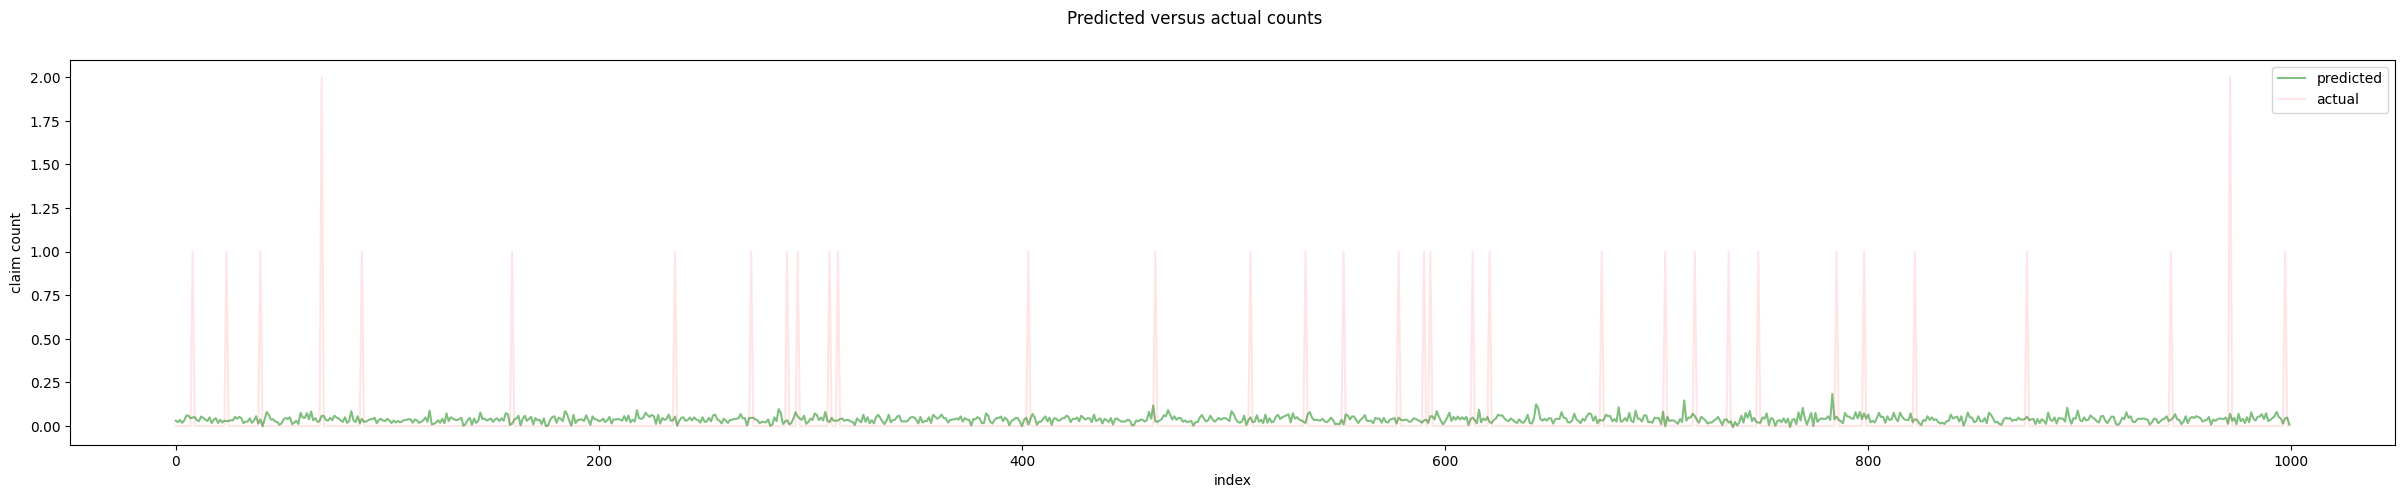

In [16]:
plot_pred_vs_actual(y_pred, y_test)

# Poisson

In [17]:
formula = "ClaimNb ~ " + " + ".join(X_train.columns)
poisson = Poisson.from_formula(formula, data=X_train.join(y_train), offset=np.log(y_train_exposure)).fit()
poisson.summary()

Optimization terminated successfully.
         Current function value: 0.158661
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542410
Model:                        Poisson   Df Residuals:                   542357
Method:                           MLE   Df Model:                           52
Date:                Tue, 30 Jan 2024   Pseudo R-squ.:                 0.03256
Time:                        20:39:23   Log-Likelihood:                -86059.
converged:                       True   LL-Null:                       -88955.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.7442      0.081    -58.918      0.000      -4.902      -4.586
Area[T.B]             0.0489      0.034      1.431      0.152      -0.018       0.116
Area[T.C]             0.0665      0.044      1.520      0.129      -0.019       0.152
Area[T.D]             0.1477      0.066      2.237      0.025       0.018       0.277
Area[T.E]             0.1529      0.088      1.742      0.082      -0.019       0.325
Area[T.F]             0.1472      0.121      1.213      0.225      -0.091       0.385
VehPower[T.5]         0.0582      0.024      2.385      0.017       0.010       0.106
VehPower[T.6]         0.1082      0.024      4.539      0.000       0.061       0.155
VehPower[T.7]         0.0858      0.024      3.614      0.000       0.039       0.132
VehPower[T.8]         0.1340      0.034      3.981      0.000       0.068       0.200
VehPower[T.9]         0.2240      0.037      6.000      0.000       0.151       0.297
VehPower[T.10]        0.2743      0.037      7.348      0.000       0.201       0.347
VehPower[T.11]        0.3423      0.047      7.347      0.000       0.251       0.434
VehPower[T.12]        0.2831      0.069      4.126      0.000       0.149       0.418
VehPower[T.13]        0.3217      0.096      3.346      0.001       0.133       0.510
VehPower[T.14]        0.2770      0.114      2.427      0.015       0.053       0.501
VehPower[T.15]        0.2574      0.115      2.234      0.025       0.032       0.483
VehBrand[T.B10]       0.0018      0.045      0.039      0.969      -0.086       0.089
VehBrand[T.B11]       0.1637      0.048      3.445      0.001       0.071       0.257
VehBrand[T.B12]      -0.3168      0.025    -12.579      0.000      -0.366      -0.267
VehBrand[T.B13]       0.0164      0.051      0.321      0.748      -0.084       0.117
VehBrand[T.B14]      -0.2108      0.100     -2.111      0.035      -0.406      -0.015
VehBrand[T.B2]       -0.0041      0.019     -0.211      0.833      -0.042       0.034
VehBrand[T.B3]        0.0402      0.027      1.500      0.134      -0.012       0.093
VehBrand[T.B4]        0.0410      0.036      1.127      0.260      -0.030       0.112
VehBrand[T.B5]        0.0834      0.031      2.692      0.007       0.023       0.144
VehBrand[T.B6]        0.0469      0.034      1.359      0.174      -0.021       0.114
VehGas[T.Regular]    -0.1630      0.015    -10.870      0.000      -0.192      -0.134
Region[T.R21]         0.0100      0.130      0.077      0.939      -0.245       0.265
Region[T.R22]         0.1188      0.069      1.718      0.086      -0.017       0.254
Region[T.R23]         0.0547      0.078      0.704      0.481      -0.098       0.207
Region[T.R24]        -0.0065      0.033     -0.197      0.843      -0.071       0.058
Region[T.R25]        -0.0377      0.060     -0.623      0.533      -0.156       0.081
Region[T.R26]         0.0370      0.066      0.559      0.576      -0.093       0.167
Region[T.R31]         0.0310      0.045      0.683      0.4

In [18]:
y_pred = poisson.predict(X_test, offset=np.log(y_test_exposure))
get_score(y_test, y_pred)

MSE: 0.0411
MAE: 0.0729
Max Error: 3.9968


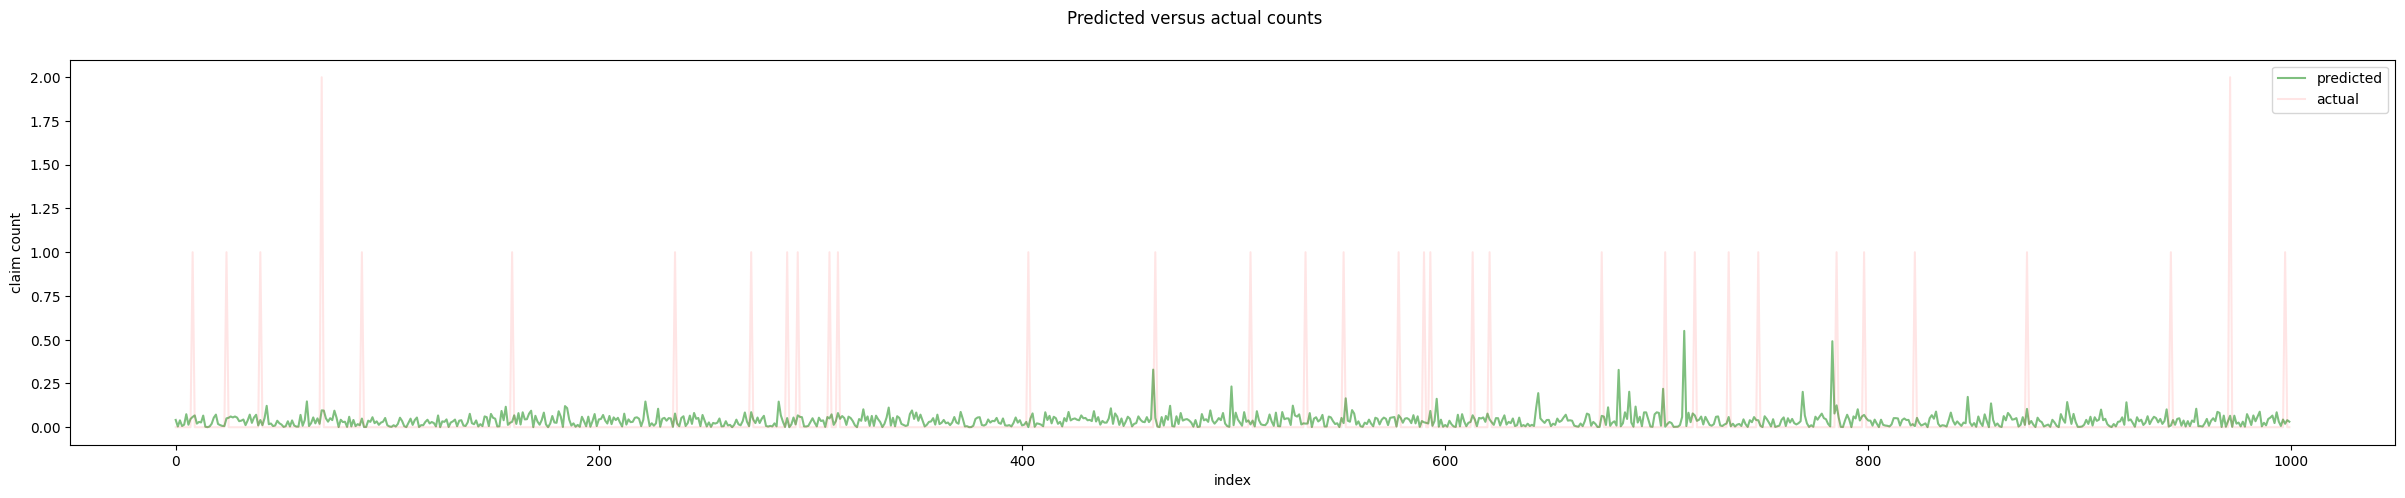

In [19]:
plot_pred_vs_actual(y_pred, y_test)

# Zero Inflated Poisson Regression

In [20]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from statsmodels.tools import add_constant

_X_train = pd.get_dummies(X_train, drop_first=True).astype("float64")
_X_test = pd.get_dummies(X_test, drop_first=True).astype("float64")

_X_train = add_constant(_X_train)
_X_test = add_constant(_X_test)

zip = ZeroInflatedPoisson(
    endog=y_train,
    exog=_X_train,
    exog_infl=_X_train,
    offset=np.log(y_train_exposure),
    inflation="logit",
).fit()
zip.summary()

         Current function value: 0.158703
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


D:\workspace\GraduateGrade2Term2LSEWT\PGPC2024\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                 ClaimNb   No. Observations:               542410
Model:             ZeroInflatedPoisson   Df Residuals:                   542357
Method:                            MLE   Df Model:                           52
Date:                 Tue, 30 Jan 2024   Pseudo R-squ.:                 0.02792
Time:                         20:42:57   Log-Likelihood:                -86082.
converged:                       False   LL-Null:                       -88555.
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inflate_const              0.3483      0.175      1.996      0.046       0.006       0.690
inflate_VehAge             0.0527      0.003     18.242      0.000       0.047       0.058
inflate_DrivAge           -0.0013      0.001     -1.197      0.231      -0.004       0.001
inflate_BonusMalus        -0.0202      0.001    -19.344      0.000      -0.022      -0.018
inflate_Density            0.0109      0.034      0.320      0.749      -0.056       0.078
inflate_Area_B             0.1679      0.068      2.469      0.014       0.035       0.301
inflate_Area_C             0.1200      0.089      1.346      0.178      -0.055       0.295
inflate_Area_D             0.0447      0.135      0.330      0.741      -0.221       0.310
inflate_Area_E             0.0006      0.181      0.003      0.997      -0.353       0.355
inflate_Area_F             0.0710      0.254      0.279      0.780      -0.427       0.569
inflate_VehPower_5         0.1435      0.052      2.783      0.005       0.042       0.245
inflate_VehPower_6         0.1399      0.050      2.786      0.005       0.041       0.238
inflate_VehPower_7         0.1102      0.050      2.226      0.026       0.013       0.207
inflate_VehPower_8         0.1131      0.070      1.619      0.105      -0.024       0.250
inflate_VehPower_9         0.0667      0.075      0.887      0.375      -0.081       0.214
inflate_VehPower_10        0.0625      0.077      0.809      0.419      -0.089       0.214
inflate_VehPower_11        0.0648      0.096      0.675      0.500      -0.123       0.253
inflate_VehPower_12        0.0896      0.141      0.633      0.526      -0.188       0.367
inflate_VehPower_13        0.0851      0.189      0.450      0.653      -0.286       0.456
inflate_VehPower_14        0.0952      0.225      0.423      0.673      -0.346       0.537
inflate_VehPower_15        0.0952      0.234      0.406      0.685      -0.364       0.555
inflate_VehBrand_B10       0.0717      0.090      0.795      0.427      -0.105       0.248
inflate_VehBrand_B11       0.0483      0.098      0.491      0.623      -0.144       0.241
inflate_VehBrand_B12       0.3317      0.054      6.140      0.000       0.226       0.438
inflate_VehBrand_B13       0.0929      0.103      0.900      0.368      -0.109       0.295
inflate_VehBrand_B14       0.1115      0.185      0.602      0.547      -0.252       0.475
inflate_VehBrand_B2        0.1140      0.039      2.920      0.003       0.037       0.191
inflate_VehBrand_B3        0.0874      0.056      1.550      0.121      -0.023       0.198
inflate_VehBrand_B4        0.0899      0.076      1.182      0.237      -0.059       0.239
inflate_VehBrand_B5        0.0555      0.064      0.873      0.383      -0.069       0.180
inflate_VehBrand_B6        0.0955      0.072      1.335      0.182      -0.045       0.236
inflate_VehGas_Regular     0.1667      0.031      5.333      0.000       0.105       0.228
inflate_Region_R21         0.1065      0.291   

In [21]:
y_pred = zip.predict(_X_test, exog_infl=_X_test, offset=np.log(y_test_exposure))
get_score(y_test, y_pred)

MSE: 0.0410
MAE: 0.0738
Max Error: 3.9958


In [ ]:
plot_pred_vs_actual(y_pred, y_test, length=2000)

# Logisitic Regression Classifier
these models seldom detect claims>1
we just treat it as a binary classification problem

In [ ]:
_y_train = (y_train > 0.5).astype(int)
_y_test = (y_test > 0.5).astype(int)
_X_train = pd.get_dummies(X_train.join(y_train_exposure), drop_first=True).astype("float64")
_X_test = pd.get_dummies(X_test.join(y_test_exposure), drop_first=True).astype("float64")


In [ ]:
# pie chart of class distribution
plt.pie(np.bincount(_y_train), labels=["0", "1"], autopct="%1.1f%%")
plt.show()

In [ ]:
# somte
from imblearn.over_sampling import SMOTE

smote = SMOTE()
_X_train_smote, _y_train_smote = smote.fit_resample(_X_train, _y_train)

plt.pie(np.bincount(_y_train_smote), labels=["0", "1"], autopct="%1.1f%%")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
# import multiprocessing
# 
# param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
#               'penalty': ['l1', 'l2'],
#               'C': np.logspace(-4, 4, 25)}
# 
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# 
# lr_rscv = RandomizedSearchCV(
#     LogisticRegression(),
#     param_grid,
#     n_iter=50,
#     verbose=3,
#     cv=cv,
#     n_jobs=multiprocessing.cpu_count() - 1,
#     scoring="accuracy",
#     return_train_score=True)
# 
# lr_rscv.fit(_X_train_smote, _y_train_smote)
# #check top performing model parameters
# best_param = lr_rscv.best_params_
# print(best_param)
# #check top performing model's score
# print(lr_rscv.best_score_)

In [ ]:
lrc = LogisticRegression().fit(_X_train_smote, _y_train_smote)
y_pred = lrc.predict(_X_test)
get_score(y_test, y_pred)

In [ ]:
plot_pred_vs_actual(y_pred, y_test, length=1000)

# Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

# todo